What are the mechanisms that cause mixing the the sill region? Other literature suggests
* Hydraulic jumps (Griffins and Leblond and their Froude number discussion)
* Internal tides (one of Rich's papers saw internal tides in Haro Strait. I don't remember if he said it causes mixing but there is potential).
* Separation induced mixing (a Rich and Farmer paper)
* Eddies in Boundary Pass (one of Ann Gargett's papers)

Can we find evidence of these features in the model?

In [47]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

from nowcast import figures

%matplotlib inline

In [48]:
def results_dataset(time, date, grid, mode):
    fname = 'SalishSea_{}_{}_{}_{}.nc'.format(time, date.strftime('%Y%m%d'),
                                              date.strftime('%Y%m%d'), grid)
    results= '/results/SalishSea/{}/'.format(mode)
    subdir=date.strftime('%d%b%y').lower()
    path = os.path.join(results,subdir,fname)
    print(path)
    dataset = nc.Dataset(path)
    
    return dataset

In [49]:
d = datetime.datetime(2015,8,1)

grid_t = results_dataset('1h',d,'grid_T','nowcast')
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
tmask = mesh.variables['tmask'][:]
tmask = 1-tmask


/results/SalishSea/nowcast/01aug15/SalishSea_1h_20150801_20150801_grid_T.nc


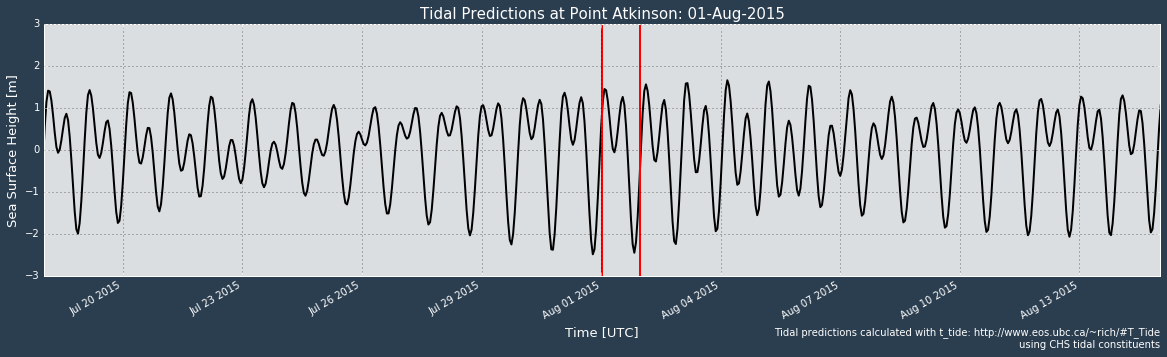

In [50]:
tidal_predictions='/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
fig=figures.PA_tidal_predictions(grid_t,tidal_predictions,PST=0)

In [51]:
sal = grid_t.variables['vosaline'][:]
tmask = tmask +np.zeros(sal.shape)
lines = np.loadtxt('/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt',delimiter=' ', dtype=int)
depth = grid_t.variables['deptht'][:]
sal = np.ma.masked_array(sal,mask=tmask)
times = grid_t.variables['time_counter']
dates= nc.num2date(times[:],times.units)

In [52]:
def plot_thalweg(t, sal, dates, lines, depth,smin=20,smax=34):
    fig,ax=plt.subplots(1,1,figsize=(20,3))
    
    salP=sal[t,:,lines[:,0],lines[:,1]]
    mesh=ax.pcolormesh(np.arange(salP.shape[0]),depth,salP.T,vmin=smin,vmax=smax)
    
    CS = ax.contour(np.arange(salP.shape[0]),depth,salP.T,[29,30,31],colors='k')
    plt.clabel(CS)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('Salinity [psu]')
    cbar.add_lines(CS)
    
    ax.set_ylim([430,0])
    ax.set_ylabel('Depth [m]')
    ax.set_title(dates[t].strftime('%d-%b-%Y %H:%M'))
    return fig

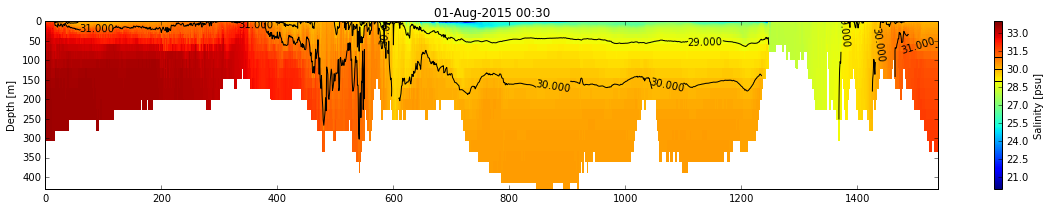

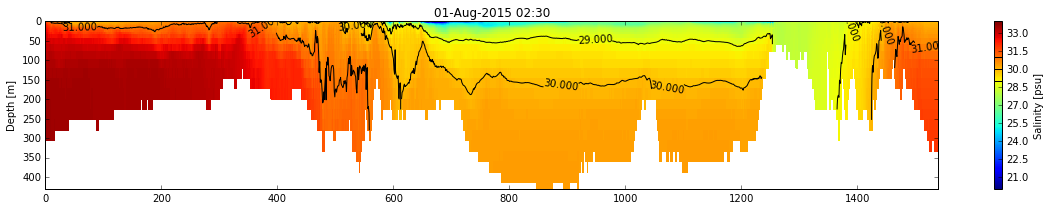

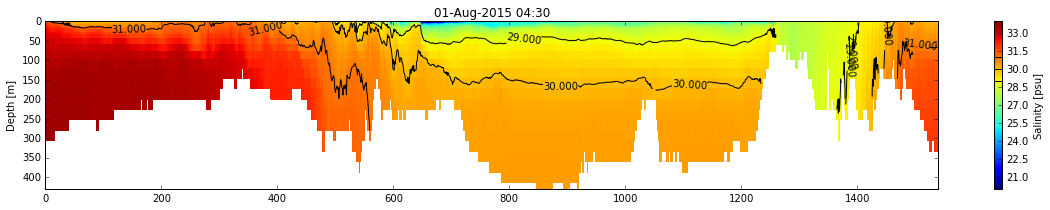

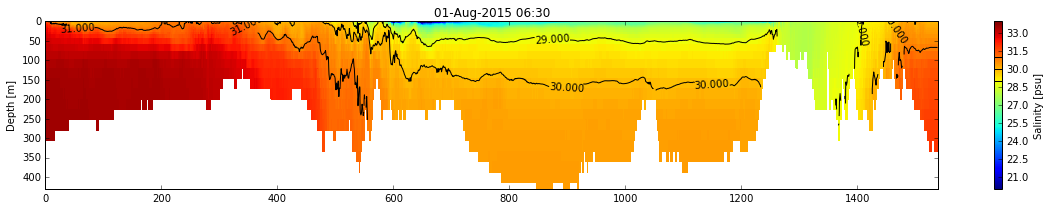

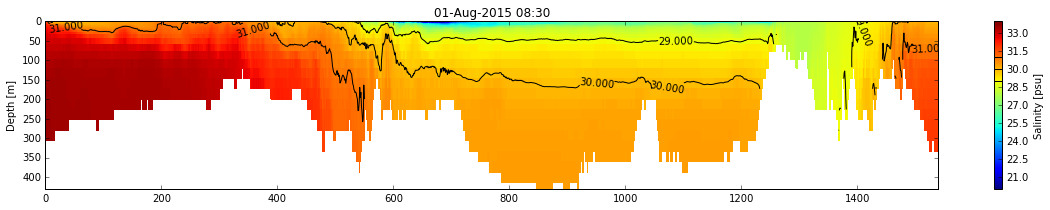

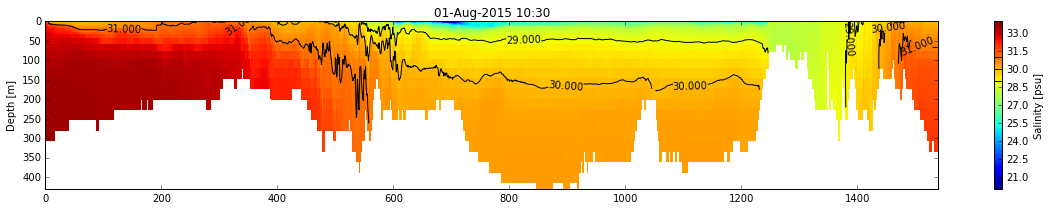

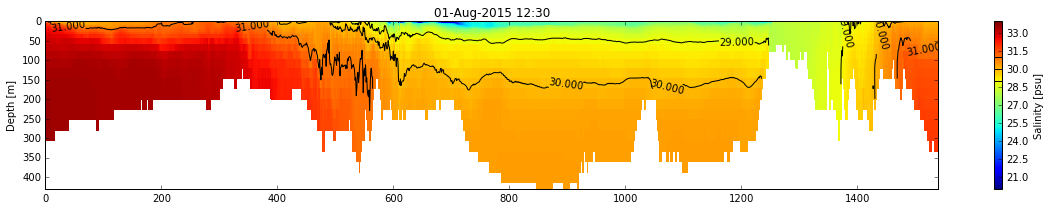

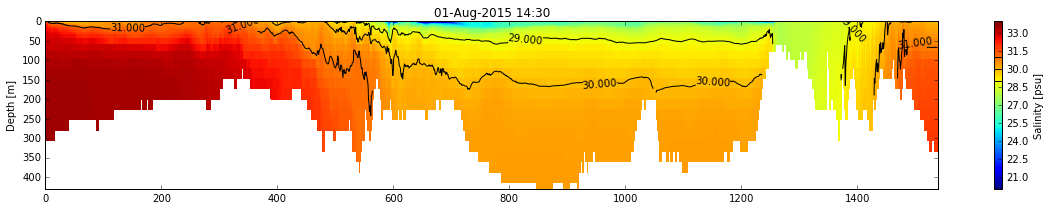

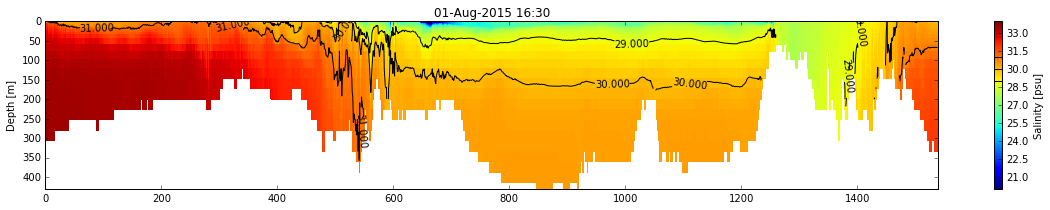

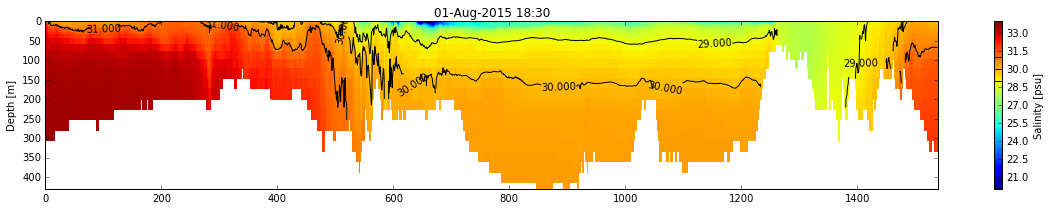

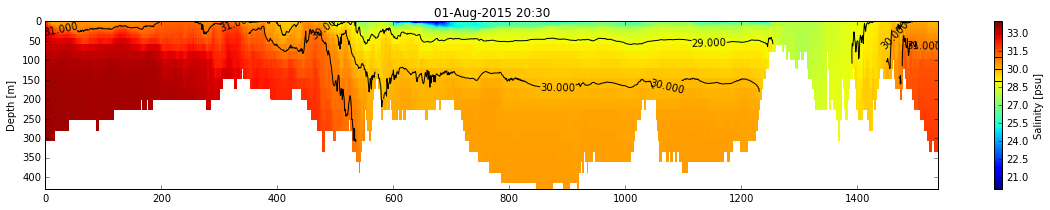

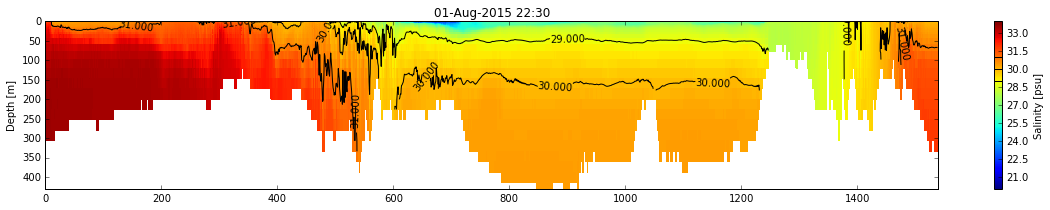

In [53]:
for t in np.arange(0,sal.shape[0],2):
    fig=plot_thalweg(t,sal,dates,lines,depth)